#  Package Imports

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#  Data dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from collections import OrderedDict

#  Load Data from GDrive

In [0]:
#  Authenticate Google Account for GDrive access (raw data is saved in GDrive)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Raw data file gdrive location: 1-lFfUd86ebnu65YNmpgdKhwkedFB9dDg
clean_data_downloaded = drive.CreateFile({'id': '1-lFfUd86ebnu65YNmpgdKhwkedFB9dDg'})
clean_data_downloaded.GetContentFile('DataCleanUp.csv')

df_parking = pd.read_csv('DataCleanUp.csv', dtype={'Ticket number': str})

#  Data Assessment

In [4]:
df_parking.head()

,Unnamed: 0,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Location,Route,...,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location,Modified_Location_Encode,Issue_Hour_Loc_Count,t_risk_level
0,0,1103341116,2015-12-21T00:00:00,1251.0,CA,HOND,PA,GY,13147 WELBY WAY,01521,...,50.0,12.0,2015,12,2015-12,Monday,WELBY WAY,45303,505,1
1,1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,525 S MAIN ST,1C51,...,50.0,14.0,2015,12,2015-12,Monday,S MAIN ST,36727,425,0
2,2,1104803000,2015-12-21T00:00:00,2055.0,CA,NISS,PA,BK,200 WORLD WAY,2R2,...,58.0,20.0,2015,12,2015-12,Monday,WORLD WAY,46336,347,0
3,3,1104820732,2015-12-26T00:00:00,1515.0,CA,ACUR,PA,WH,100 WORLD WAY,2F11,...,NaN,15.0,2015,12,2015-12,Saturday,WORLD WAY,46336,404,0
4,4,1105461453,2015-09-15T00:00:00,115.0,CA,CHEV,PA,BK,GEORGIA ST OLYMPIC,1FB70,...,93.0,1.0,2015,9,2015-09,Tuesday,GEORGIA ST OLYMPIC,63071,1332,1


In [5]:
df_parking.shape

(6751096, 23)

In [6]:
df_parking.dtypes

Unnamed: 0                    int64
Ticket number                object
Issue Date                   object
Issue time                  float64
RP State Plate               object
Make                         object
Body Style                   object
Color                        object
Location                     object
Route                        object
Agency                      float64
Violation code               object
Violation Description        object
Fine amount                 float64
Issue_Hour                  float64
Issue_Year                    int64
Issue_Month                   int64
Issue_Month_Year             object
Issue_Weekday                object
Modified_Location            object
Modified_Location_Encode      int64
Issue_Hour_Loc_Count          int64
t_risk_level                  int64
dtype: object

In [0]:
#  Remove 'Unnamed: 0' column
df_parking.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
df_parking.shape

(6751096, 22)

In [9]:
df_parking.head()

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Location,Route,Agency,...,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location,Modified_Location_Encode,Issue_Hour_Loc_Count,t_risk_level
0,1103341116,2015-12-21T00:00:00,1251.0,CA,HOND,PA,GY,13147 WELBY WAY,01521,1.0,...,50.0,12.0,2015,12,2015-12,Monday,WELBY WAY,45303,505,1
1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,525 S MAIN ST,1C51,1.0,...,50.0,14.0,2015,12,2015-12,Monday,S MAIN ST,36727,425,0
2,1104803000,2015-12-21T00:00:00,2055.0,CA,NISS,PA,BK,200 WORLD WAY,2R2,2.0,...,58.0,20.0,2015,12,2015-12,Monday,WORLD WAY,46336,347,0
3,1104820732,2015-12-26T00:00:00,1515.0,CA,ACUR,PA,WH,100 WORLD WAY,2F11,2.0,...,NaN,15.0,2015,12,2015-12,Saturday,WORLD WAY,46336,404,0
4,1105461453,2015-09-15T00:00:00,115.0,CA,CHEV,PA,BK,GEORGIA ST OLYMPIC,1FB70,1.0,...,93.0,1.0,2015,9,2015-09,Tuesday,GEORGIA ST OLYMPIC,63071,1332,1


#  Confusion Matrix

In [0]:
def CMatrix(CM, labels=['No Citation', 'Citation']):
  df = pd.DataFrame(data=CM, index=labels, columns=labels)
  df.index.name='TRUE'
  df.columns.name='PREDICTION'
  df.loc['Total']=df.sum()
  df['Total']=df.sum(axis=1)
  return df

In [0]:
#  Evaluation metrics' dataframe
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'],
                      columns=['NULL', 'LogisticReg', 'ClassTree', 'NaiveBayes'])

In [0]:
#  Define X and y
feature_col = ['Issue_Hour', 'Modified_Location_Encode']
X = df_parking[feature_col]
y = df_parking.t_risk_level

In [0]:
#  Split into training / testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL']=accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'NULL']=precision_score(y_pred=y_pred_test, y_true=y_test, average='micro')
metrics.loc['recall', 'NULL']=recall_score(y_pred=y_pred_test, y_true=y_test, average='micro')

CM=confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,No Citation,Citation,Total
TRUE,,,
No Citation,0,506583,506583
Citation,0,843637,843637
Total,0,1350220,1350220


**Key**
*  Accuracy = Overall probability of model's prediction accuracy
*  Precision = When 'Citation' is predicted, what is the probability that this is correct?
* Recall = The probability of actual citation

#  ML Algorithm 1:  Logistic Regression

In [17]:
# Train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
# Create prediction class for the testing set
y_pred_class = logreg.predict(X_test)

#  Logistic Regression:  Accuracy Assessment

** Classificiation accuracy: **
Percentage of correct predictions

In [0]:
# calculate accuracy
from sklearn import metrics
#print(metrics.accuracy_score(y_test, y_pred_class))

In [0]:
#  examine the class distribution of the testing set
#y_test.value_counts()

In [0]:
#  calculate the percentage of 1s -->  we can just use mean because we only have two values
#y_test.mean()

In [0]:
# calculate the percentage of 0s
#1 - y_test.mean()

In [0]:
# calculate null accuracy (for binary classification problems coded as 0/1)
#max(y_test.mean(), 1 - y_test.mean())

In [0]:
# print the first 25 true and predicted responses
#print('True:', y_test.values[0:25])
#print('Pred:', y_pred_class[0:25])

#  Confusion Matrix

In [0]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

**  Metric 1:  ** 
Classification Accuracy

In [0]:
#print((TP + TN) / float(TP + TN + FP + FN))
#print(metrics.accuracy_score(y_test, y_pred_class))

** Metric 2:  **
Classification Error

In [0]:
#print((FP + FN) / float(TP + TN + FP + FN))
#print(1 - metrics.accuracy_score(y_test, y_pred_class))

** Metric 3: ** 
Sensitivity

In [0]:
#print(TP / float(TP + FN))
#print(metrics.recall_score(y_test, y_pred_class))

** Metric 4: **
Specificity

In [0]:
#print(TN / float(TN + FP))

**  Metric 5:**
False Positive Rate


In [0]:
#print(FP / float(TN + FP))

** Metric 6: **
Precision

In [0]:
#print(TP / float(TP + FP))
#print(metrics.precision_score(y_test, y_pred_class))

#  Logistic Regression:  ROC Curve

In [72]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 0])

In [73]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10, :]

array([[0.43073001, 0.56926999],
       [0.43674653, 0.56325347],
       [0.60709211, 0.39290789],
       [0.61709435, 0.38290565],
       [0.34314096, 0.65685904],
       [0.45897149, 0.54102851],
       [0.50574889, 0.49425111],
       [0.4116393 , 0.5883607 ],
       [0.18461579, 0.81538421],
       [0.66157886, 0.33842114]])

In [74]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([0.56926999, 0.56325347, 0.39290789, 0.38290565, 0.65685904,
       0.54102851, 0.49425111, 0.5883607 , 0.81538421, 0.33842114])

In [0]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [0]:
# plot predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt

Text(0,0.5,'Frequency')

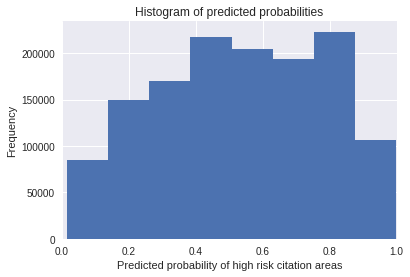

In [77]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of high risk citation areas')
plt.ylabel('Frequency')

**Conclusion from the histogram **

Large number of probability are < 0.5 classification threshold.  Solution:  Adjust the classifer to 0.4 so the classifier is more sensitive to postive instances.

In [0]:
#  Lower threshold to 0.4
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.4)[0]

In [79]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([0.56926999, 0.56325347, 0.39290789, 0.38290565, 0.65685904,
       0.54102851, 0.49425111, 0.5883607 , 0.81538421, 0.33842114])

In [80]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([1., 1., 0., 0., 1., 1., 1., 1., 1., 0.])

In [88]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[293610 212973]
 [137263 706374]]


In [89]:
# new confusion matrix (threshold of 0.4)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[293610 212973]
 [137263 706374]]


In [90]:
# sensitivity has increased (used to be 0.70)
print(706374 / float(706374 + 137263))

0.8372961356602425


In [91]:
# specificity has decreased (used to be 0.80)
print(293610 / float(293610 + 212973))

0.57958912952073


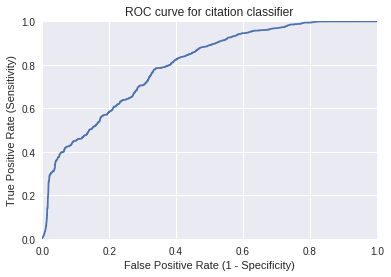

In [92]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for citation classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [0]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [94]:
evaluate_threshold(0.5)

Sensitivity: 0.7009033506116967
Specificity: 0.7111805962695156


In [95]:
evaluate_threshold(0.3)

Sensitivity: 0.9246370180539735
Specificity: 0.44452340485172226


In [96]:
evaluate_threshold(0.7)

Sensitivity: 0.4297393310155908
Specificity: 0.9150603158811093


In [97]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.798049973193619

**  Evaluate Logistic Regression Model **

In [0]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'],
                      columns=['NULL', 'LogisticReg', 'ClassTree', 'NaiveBayes'])

In [0]:
y_pred_test = logreg.predict(X_test)
metrics.loc['accuracy', 'LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)


In [100]:
#  Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,No Citation,Citation,Total
TRUE,,,
No Citation,360272,146311,506583
Citation,252329,591308,843637
Total,612601,737619,1350220


#  ML Algorithm 2)  Classification Trees

In [0]:
classTree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

In [102]:
classTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=30,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [0]:
#  Evaluate the model
y_pred_test = classTree.predict(X_test)
metrics.loc['accuracy', 'ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)

In [104]:
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,No Citation,Citation,Total
TRUE,,,
No Citation,506583,0,506583
Citation,0,843637,843637
Total,506583,843637,1350220


#  ML Algorithm 3)  Naive Bayes Classifer

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
naiveBayes = GaussianNB()

In [107]:
naiveBayes.fit(X_train, y_train)

GaussianNB(priors=None)

In [0]:
#  Evaluate the model
y_pred_test = naiveBayes.predict(X_test)
metrics.loc['accuracy', 'NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

In [109]:
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,No Citation,Citation,Total
TRUE,,,
No Citation,422047,84536,506583
Citation,583,843054,843637
Total,422630,927590,1350220


#  Model Evaluation

In [110]:
100*metrics

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,NaN,70.4759,100,93.6959
precision,NaN,80.1644,100,90.8865
recall,NaN,70.0903,100,99.9309


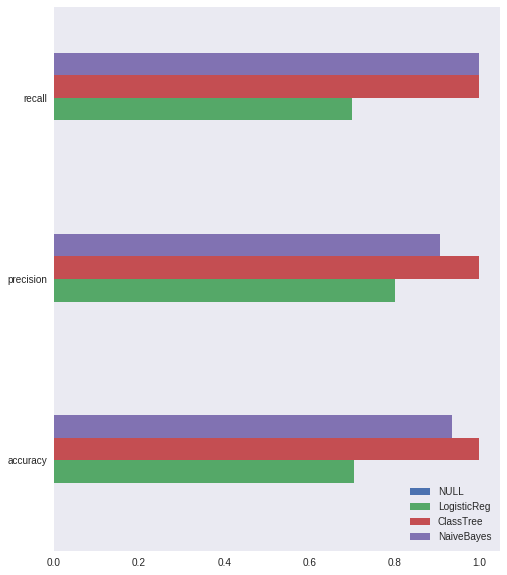

In [111]:
fig, ax = plt.subplots(figsize=(8,10))
metrics.plot(kind='barh', ax=ax)
ax.grid()

#  Conclusion:  Predictions

In [129]:
df_parking[df_parking.Modified_Location_Encode == 36727]

,Ticket number,Issue Date,Issue time,RP State Plate,Make,Body Style,Color,Location,Route,Agency,...,Fine amount,Issue_Hour,Issue_Year,Issue_Month,Issue_Month_Year,Issue_Weekday,Modified_Location,Modified_Location_Encode,Issue_Hour_Loc_Count,t_risk_level
1,1103700150,2015-12-21T00:00:00,1435.0,CA,GMC,VN,WH,525 S MAIN ST,1C51,1.0,...,50.0,14.0,2015,12,2015-12,Monday,S MAIN ST,36727,425,0
47777,1111383416,2016-01-05T00:00:00,219.0,CA,MAZD,PA,GY,646 S MAIN ST,00601,56.0,...,73.0,2.0,2016,1,2016-01,Tuesday,S MAIN ST,36727,1127,1
55789,1112951770,2016-01-04T00:00:00,1957.0,CA,TOYO,PA,WH,1804 S MAIN ST,00195,1.0,...,50.0,19.0,2016,1,2016-01,Monday,S MAIN ST,36727,358,0
77420,1109572752,2016-01-13T00:00:00,742.0,CA,BMW,PA,BL,4166 S MAIN ST,00544,55.0,...,93.0,7.0,2016,1,2016-01,Wednesday,S MAIN ST,36727,612,1
77421,1109572763,2016-01-13T00:00:00,743.0,CA,BMW,PA,BL,4166 S MAIN ST,00544,55.0,...,25.0,7.0,2016,1,2016-01,Wednesday,S MAIN ST,36727,612,1
94817,1109574395,2016-01-15T00:00:00,755.0,CA,BMW,PA,BK,8324 S MAIN ST,549A,55.0,...,93.0,7.0,2016,1,2016-01,Friday,S MAIN ST,36727,612,1
108995,1113871441,2016-01-18T00:00:00,1410.0,CA,ACUR,PA,WH,1720 S MAIN ST,207W,51.0,...,63.0,14.0,2016,1,2016-01,Monday,S MAIN ST,36727,425,0
108996,1113871452,2016-01-18T00:00:00,1412.0,CA,JEEP,PA,WH,1720 S MAIN ST,207W,51.0,...,63.0,14.0,2016,1,2016-01,Monday,S MAIN ST,36727,425,0
117186,1111379006,2016-01-21T00:00:00,205.0,CA,HOND,PA,GY,807 S MAIN ST,00601,56.0,...,73.0,2.0,2016,1,2016-01,Thursday,S MAIN ST,36727,1127,1
124191,1109008014,2016-01-19T00:00:00,1715.0,CA,TOYO,PA,GR,525 S MAIN ST,1C51,1.0,...,50.0,17.0,2016,1,2016-01,Tuesday,S MAIN ST,36727,380,0


In [141]:
df_parking.dtypes

Ticket number                object
Issue Date                   object
Issue time                  float64
RP State Plate               object
Make                         object
Body Style                   object
Color                        object
Location                     object
Route                        object
Agency                      float64
Violation code               object
Violation Description        object
Fine amount                 float64
Issue_Hour                  float64
Issue_Year                    int64
Issue_Month                   int64
Issue_Month_Year             object
Issue_Weekday                object
Modified_Location            object
Modified_Location_Encode      int64
Issue_Hour_Loc_Count          int64
t_risk_level                  int64
dtype: object

In [0]:
def input_new_prediction(input_data):
  data = input_data.values.reshape(1, -1)
  prob = logreg.predict_proba(data)[0][1]
  if prob >= 0.7:
    return 'Do not park there!  There is a high risk of citation!'
  else:
    return 'Safe to park there! There is a low risk of citation'

In [0]:
from collections import Ordered Dict
def input_prompt(input_data):
  

In [153]:
from collections import OrderedDict
new_data = OrderedDict([('Issue_Hour', 2),
                       ('Modified_Location_Encode', 36727)])
new_data = pd.Series(new_data)
input_new_prediction(new_data)

'Do not park there!  There is a high risk of citation!'